In [ ]:
#@title License and Disclaimer

'''
This project is intended to serve as an academic tutorial to help with research
efforts and understanding of AI architecture design.

The Cifar-100 dataset is used here for demonstration purposes, and is cited
below.

Learning Multiple Layers of Features from Tiny Images, Alex Krizhevsky, 2009.
(University of Toronto)
Source: https://www.cs.toronto.edu/~kriz/cifar.html

The following is in respect of the software portion of the material presented
here.

Copyright (c) 2023 Parham Faraji

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.
'''

In [ ]:
#@title Data Import

import tensorflow as tf
import numpy as np

# Construct a dataset
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar100.load_data(label_mode='coarse')


169001437/169001437 [==============================] - 2s 0us/step


In [ ]:
#@title Normalization and One-Hot Functions

from tqdm import tqdm

def normalize(cluster):
  # clusterNorm = (cluster - 127.5) / 127.5
  clusterNorm = cluster / 255
  del cluster
  return clusterNorm

def hot(arr, nc=20): # nc = number of classes
  arr = np.squeeze(arr)
  arr = tf.one_hot(arr, nc)
  print(arr.shape, *np.sum(arr, axis=0))
  return arr

In [ ]:
#@title Preparing Data
# del V, Yv, X, Yx
V = normalize(test_images) # 10000
X = normalize(train_images) # 50000
print(V.shape[1:], np.min(V), np.max(V))

# balance-report
Yv = hot(test_labels)
Yx = hot(train_labels)


(32, 32, 3) 0.0 1.0
(10000, 20) 500.0 500.0 500.0 500.0 500.0 500.0 500.0 500.0 500.0 500.0 500.0 500.0 500.0 500.0 500.0 500.0 500.0 500.0 500.0 500.0
(50000, 20) 2500.0 2500.0 2500.0 2500.0 2500.0 2500.0 2500.0 2500.0 2500.0 2500.0 2500.0 2500.0 2500.0 2500.0 2500.0 2500.0 2500.0 2500.0 2500.0 2500.0


In [ ]:
#@title Layer Designer (2D) Function

from tensorflow import keras

# This approach helps make design intuitive, intelligible, and easy to alter
# No need to worry about the order of operations
# You simply enable certain sub-layers and focus on the grand architecture
# It is especially useful as a tool for beginners to start from the middle by fiddling around
# The "engage" variable in the function is responsible for enabling all operations needed for a composite layer
# Using default parameters, layers can be on autopilot by verifying input/"consign" alone
def layer2D_global(consign, engage=[1,0,0,1,0,0], fmaps=24, k=(3,3), act='relu', step=(1,1), pool=(2,2), scale=(2,2), dp=.20, ep=1e-5, pad='same'): # same/valid

  # preset-choices:
  if engage[0]==1:
    consign = keras.layers.Conv2D(filters=fmaps, kernel_size=k, strides=step, padding=pad)(consign)
  if engage[0]==2:
    consign = keras.layers.Conv2DTranspose(filters=fmaps, kernel_size=k, strides=step, padding=pad)(consign)
  if engage[0]==3:
    attn = keras.layers.MultiHeadAttention(num_heads=3, key_dim=fmaps)
    consign = attn(consign, consign)

  if engage[1]:
    consign = keras.layers.BatchNormalization()(consign)
  if engage[2]:
    consign = keras.layers.LayerNormalization(epsilon=ep)(consign)
  if engage[3]:
    consign = keras.layers.Activation(act)(consign)
  if engage[4]:
    consign = keras.layers.MaxPooling2D(pool)(consign)
  if engage[5]:
    consign = keras.layers.UpSampling2D(scale, interpolation='bicubic')(consign)
  if engage[6]:
    consign = keras.layers.Dropout(dp)(consign)

  return consign

# We could narrow down choices using a subset, for a simplified demonstration
def layer(input, engage, fmaps, k, act, step=(1,1), pool=(2,2), pad='same', dp=0.55): # same/valid
  conv = keras.layers.Conv2D(filters=fmaps, kernel_size=k, strides=step, padding=pad)(input)

  # preset-choices:
  if engage[0]:
    conv = keras.layers.BatchNormalization()(conv)
  if engage[1]:
    conv = keras.layers.Activation(act)(conv)
  if engage[2]:
    conv = keras.layers.MaxPooling2D(pool)(conv)
  if engage[3]:
    conv = keras.layers.Dropout(dp)(conv)

  return conv


In [ ]:
#@title Classification Model Demo

'''Here we sketch a classifier 8-9 layers deep and 2-3 wide'''
def architect(nc=20): # nc = number of classes

  # lunch
  inputshape = [32,32,3]
  inputlayer = keras.layers.Input(inputshape)

  # simplified-body-1
  a1 = layer(inputlayer, [1,1,0,0], fmaps=20, k=(5,5), act='relu')
  a1 = layer(a1,         [1,1,1,1], fmaps=20, k=(4,4), act='relu', pool=(2,2))
  a1 = layer(a1,         [1,1,0,0], fmaps=20, k=(3,3), act='relu')

  # simplified-body-2
  b1 = layer(inputlayer, [0,1,0,0], fmaps=20, k=(2,7), act='relu')
  b1 = layer(b1,         [0,1,0,0], fmaps=20, k=(7,2), act='relu', step=(2,2))
  b1 = layer(b1,         [0,1,0,0], fmaps=20, k=(3,3), act='relu')

  # simplified-body-3
  c1 = layer(inputlayer, [1,1,0,0], fmaps=20, k=(3,3), act='relu')
  c1 = layer(c1,         [0,1,1,1], fmaps=20, k=(4,4), act='relu', pool=(2,1))
  c1 = layer(c1,         [1,1,1,0], fmaps=20, k=(4,4), act='relu', pool=(1,2))
  c1 = layer(c1,         [1,1,0,1], fmaps=20, k=(3,3), act='relu')

  # residual=inputlayer
  res = layer(inputlayer, [1,1,0,0], fmaps=20, k=1, act='relu', step=(2,2))

  # merge
  con = keras.layers.Concatenate()([res, a1, b1, c1])
  con = keras.layers.BatchNormalization()(con)

  # 2nd-lvl-body-1
  a2 = layer(con, [1,1,0,0], fmaps=40, k=(4,4), act='relu')
  a2 = layer(a2,  [1,1,0,1], fmaps=20, k=(4,4), act='relu')
  a2 = layer(a2,  [1,1,0,0], fmaps=20, k=(3,3), act='relu')

  # 2nd-lvl-body-2
  b2 = layer(con, [1,1,0,0], fmaps=40, k=(5,5), act='relu')
  b2 = layer(b2,  [1,1,0,0], fmaps=20, k=(3,3), act='relu')
  b2 = layer(b2,  [1,1,0,0], fmaps=20, k=(2,2), act='relu')

  # residual
  res2 = layer(con, [1,1,0,0], fmaps=20, k=1, act='relu')

  # merge 2
  con2 = keras.layers.Concatenate()([res2, a2, b2])
  con2 = keras.layers.BatchNormalization()(con2)

  # finalization
  sf0 = layer(con2, [1,1,0,1], fmaps=20, k=4, act='relu')
  sf = layer(sf0,   [1,1,0,1], fmaps=20, k=3, act='relu')

  # merge 3
  con3 = keras.layers.Concatenate()([a2, sf0, sf])

  gap = keras.layers.GlobalAveragePooling2D()(con3)
  outputlayer = keras.layers.Dense(nc, activation='softmax')(gap)

  return inputlayer, outputlayer


# tie classifier:
input, output = architect()
model = keras.models.Model(inputs=input, outputs=output)

# compile model:
model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adam(learning_rate=0.0015),
              metrics=['accuracy'])

# print model
model.summary()

# implement callbacks:
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.75,
                patience=4, min_lr=1e-4)

es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='auto',
                verbose=1, patience=30, restore_best_weights=True)

cp = keras.callbacks.ModelCheckpoint(
                './best_checkpoint', monitor="val_loss", verbose=0,
                save_best_only=True, save_weights_only=False, mode="auto",
                save_freq="epoch", initial_value_threshold=1.35) # *threshold based on a previous test run

# fit data into model
model.fit(x=X, y=Yx, batch_size=1000, epochs=150, verbose=1, # *batch size based on available hardware
                validation_data=(V, Yv), shuffle=True,
                callbacks=[reduce_lr, es, cp]) # or [reduce_lr, es]

# Save model
model.save('NTC')

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv2d_17 (Conv2D)          (None, 32, 32, 20)           560       ['input_2[0][0]']             
                                                                                                  
 batch_normalization_10 (Ba  (None, 32, 32, 20)           80        ['conv2d_17[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_17 (Activation)  (None, 32, 32, 20)           0         ['batch_normalization_10[0

In [ ]:
#@title Sample Prediction

from tensorflow.keras.models import load_model
'''either load or use existing model'''
# modelcp = load_model('NTC')
predictions = model.predict(V[::1200])

1/1 [==============================] - 1s 787ms/step


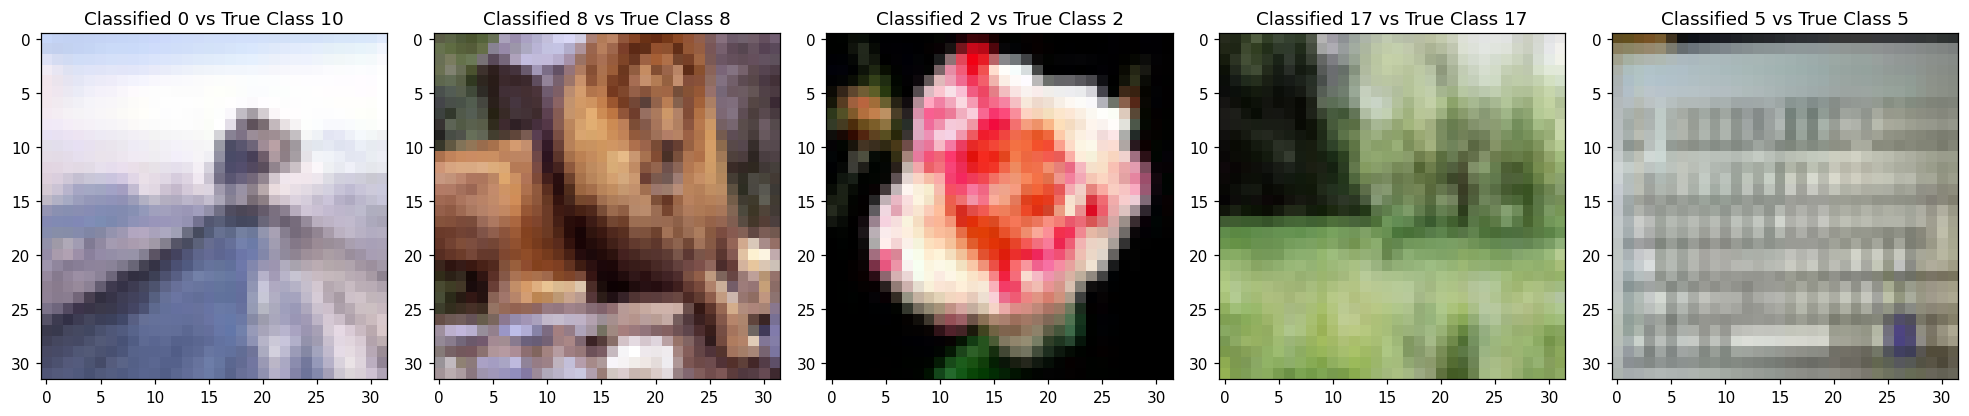

In [ ]:
#@title Sample Visualization

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(18, 6), dpi=110)
for n in range(1,6):
  fig.add_subplot(1, 5, n)
  plt.title(f'Classified {str(np.argmax(predictions[n-1]))} vs True Class {str(np.argmax(Yv[::1200][n-1]))}')
  plt.imshow(V[::1200][n-1])

plt.tight_layout()
# plt.show()
plt.savefig('NTClassifierResults.png', format='png')

In [ ]:
'''
0: aquatic_mammals
1: fish
2: flowers
3: food_containers
4: fruit_and_vegetables
5: household_electrical_devices
6: household_furniture
7: insects
8: large_carnivores
9: large_man-made_outdoor_things
10: large_natural_outdoor_scenes
11: large_omnivores_and_herbivores
12: medium_mammals
13: non-insect_invertebrates
14: people
15: reptiles
16: small_mammals
17: trees
18: vehicles_1
19: vehicles_2
'''